# WICCA: Wavelet-based Image Compression & Classification Analysis

WICCA is a research framework exploring the impact of wavelet compression on image classification performance.
The current goal is to assess whether reducing image size via Haar wavelet transformation retains enough information for accurate classification.

### Objectives
- Apply Haar wavelet compression to large images (>2K resolution).
- Evaluate classification performance on both original and compressed images.
- Compare results across multiple pre-trained models.


## Imports

In [27]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.applications as apps
from settings.constants import SIM_CLASSES, SIM_CLASSES_PERC, SIM_BEST_CLASS

import plotly.express as px
import plotly.graph_objects as go

import utility.result_manager as rsltmgr
from utility.data_loader import load_image
from utility.wavelet_coder import HaarCoder
from utility.classifying_tools import load_classifier, ClassifierProcessor

%matplotlib inline
pd.set_option('display.float_format', '{:.5f}'.format)

## Models
Trained image classifiers: https://keras.io/api/applications/

In [28]:
classifiers = {
    'MobileNetV2': load_classifier(apps.mobilenet_v2.MobileNetV2),
    'VGG16': load_classifier(apps.vgg16.VGG16),
    'VGG19': load_classifier(apps.vgg19.VGG19),
    'ResNet50': load_classifier(apps.resnet50.ResNet50),
    'NASNetMobile': load_classifier(apps.nasnet.NASNetMobile),
    'NASNetLarge': load_classifier(apps.nasnet.NASNetLarge, shape=(331, 331))
}

## Analysis

### Data
First let's have a look on our images.

Number of images: 130


Text(0.5, 1.0, 'pp_124.jpg, shape: (5399, 8099, 3)')

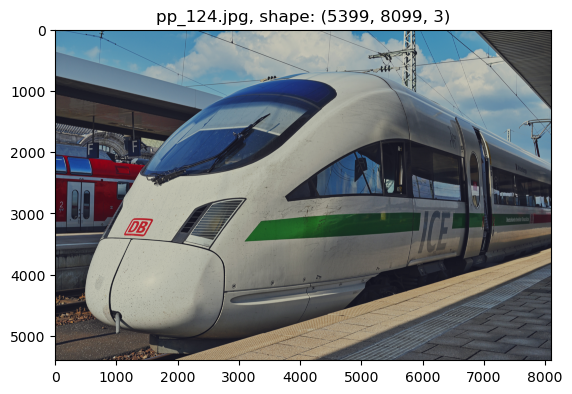

In [29]:
path = 'data/orig'
list_dir = os.listdir(path)
print('Number of images:', len(list_dir))

# Sample
index = 35

name = list_dir[index]
sample = load_image(f'{path}/{name}')

plt.imshow(sample)
plt.title(f'{name}, shape: {sample.shape}')

We can say this is one of the core functions in the framework that starts our analysis.
In the future, I am going to implement some better error handling and work more with the timer. For now, the timer just shuts down the whole process and does not take into consideration what classifiers are currently working.

**Please be aware, that process might take quite a while.**

In [30]:
depth = 10

results_folder = os.path.join("results", f"depth_{depth}")
processor = ClassifierProcessor(path=path,
                                coder=HaarCoder(),              # defines our wavelet
                                depth=depth,                        # defines the depth of transforming
                                top=5,                          # defines top classes for comparison
                                interpolation=cv2.INTER_AREA,
                                results_folder=results_folder,
                                rsltmgr=rsltmgr)

# results = processor.process_classifier((classifiers['MobileNetV2']))
results = processor.process_all_classifiers(classifiers, timeout=3600)

Let's have a look on how our image was transformed

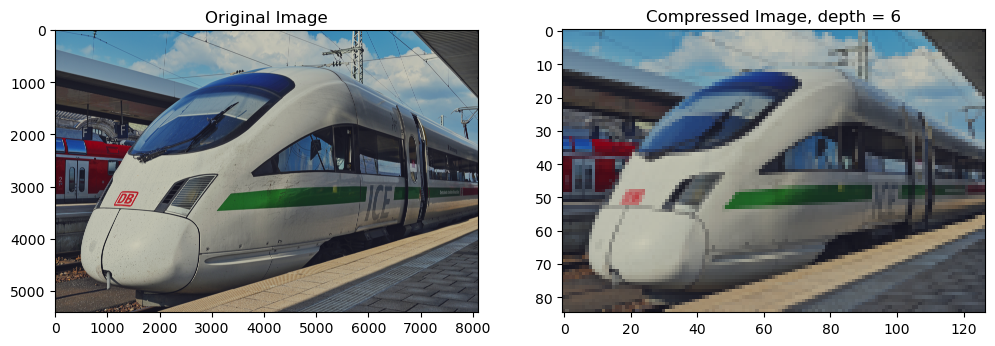

Original size: (5399, 8099, 3)
Compressed size: (85, 127, 3)


In [31]:
processor.show_image_vs_icon(sample)

 ## For single/current depth
Let's look on classifying comparison with one certain depth

### MobileNetV2

In [32]:
# rsltmgr.load_summary_results(depth, 'MobileNetV2') # We can call results either by loading csv
results['MobileNetV2'] # By directly looking into "results" dataframe in case of multi classifier analysis
# results # Or by directly looking into dataframe for independent classifier analysis

,similar classes (count),similar classes (%),similar best class
count,130.00000,130.00000,130.00000
mean,2.73846,54.76923,0.50769
std,1.37843,27.56853,0.50187
min,0.00000,0.00000,0.00000
25%,2.00000,40.00000,0.00000
50%,3.00000,60.00000,1.00000
75%,4.00000,80.00000,1.00000
max,5.00000,100.00000,1.00000


### VGG16

In [33]:
results['VGG16']

,similar classes (count),similar classes (%),similar best class
count,130.00000,130.00000,130.00000
mean,3.53077,70.61538,0.63077
std,1.14924,22.98479,0.48446
min,0.00000,0.00000,0.00000
25%,3.00000,60.00000,0.00000
50%,4.00000,80.00000,1.00000
75%,4.00000,80.00000,1.00000
max,5.00000,100.00000,1.00000


### VGG19

In [34]:
results['VGG19']

,similar classes (count),similar classes (%),similar best class
count,130.00000,130.00000,130.00000
mean,3.56923,71.38462,0.65385
std,1.21960,24.39195,0.47758
min,0.00000,0.00000,0.00000
25%,3.00000,60.00000,0.00000
50%,4.00000,80.00000,1.00000
75%,4.00000,80.00000,1.00000
max,5.00000,100.00000,1.00000


### ResNet50

In [35]:
results['ResNet50']

,similar classes (count),similar classes (%),similar best class
count,130.00000,130.00000,130.00000
mean,3.05385,61.07692,0.55385
std,1.20921,24.18425,0.49902
min,0.00000,0.00000,0.00000
25%,2.00000,40.00000,0.00000
50%,3.00000,60.00000,1.00000
75%,4.00000,80.00000,1.00000
max,5.00000,100.00000,1.00000


### NASNetMobile

In [36]:
results['NASNetMobile']

,similar classes (count),similar classes (%),similar best class
count,130.00000,130.00000,130.00000
mean,3.38462,67.69231,0.68462
std,1.27823,25.56458,0.46647
min,0.00000,0.00000,0.00000
25%,3.00000,60.00000,0.00000
50%,4.00000,80.00000,1.00000
75%,4.00000,80.00000,1.00000
max,5.00000,100.00000,1.00000


### NASNetLarge

In [37]:
results['NASNetLarge']

,similar classes (count),similar classes (%),similar best class
count,130.00000,130.00000,130.00000
mean,3.34615,66.92308,0.60769
std,1.23710,24.74196,0.49015
min,0.00000,0.00000,0.00000
25%,3.00000,60.00000,0.00000
50%,4.00000,80.00000,1.00000
75%,4.00000,80.00000,1.00000
max,5.00000,100.00000,1.00000


### Compare classifiers

In [38]:
names = []
mean_sim_clas_perc = []
mean_sim_best_clas = []

for name, df in results.items():
  names.append(name)
  mean_sim_clas_perc.append(df.iat[1, 1])
  mean_sim_best_clas.append(df.iat[1, 2] * 100)

In [39]:
def plot_metric_radar(metric, title: str = None) -> None :
    fig = go.Figure(data=go.Scatterpolar(
        r=metric,
        theta=names,
        fill="toself",
        name="Similar classes %",
        fillcolor='rgba(0,100,80,0.2)',
        # line_color=dict(color='azure')
    ))
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[min(metric) * 0.9, max(metric) * 1.1]
            ),
        ),
        showlegend=False,
        title=title
    )
    fig.show()

### Similar classes

In [40]:
plot_metric_radar(mean_sim_clas_perc, "Similar classes % (mean)")

### The best class similarity

In [41]:
plot_metric_radar(mean_sim_best_clas, "Best class similarity % (mean)")

In [42]:
# Create a scatter plot
fig = px.scatter(
    x=mean_sim_clas_perc,
    y=mean_sim_best_clas,
    text=names,
    labels={'x': 'Similar classes, %', 'y': 'Best class similarity, %'},
    title='Classifier Performance Comparison'
)

# Adjust text positioning
fig.update_traces(textposition='top center', marker_size=12)

# Add a line for reference
fig.add_shape(
    type="line",
    x0=min(mean_sim_clas_perc) * 0.95,
    y0=min(mean_sim_best_clas) * 0.95,
    x1=max(mean_sim_clas_perc) * 1.05,
    y1=max(mean_sim_best_clas) * 1.05,
    line=dict(color="Gray", width=1, dash="dash")
)

fig.show()

##  Results comparison for different depths
In this block we compare classifying performance by multiple classifiers

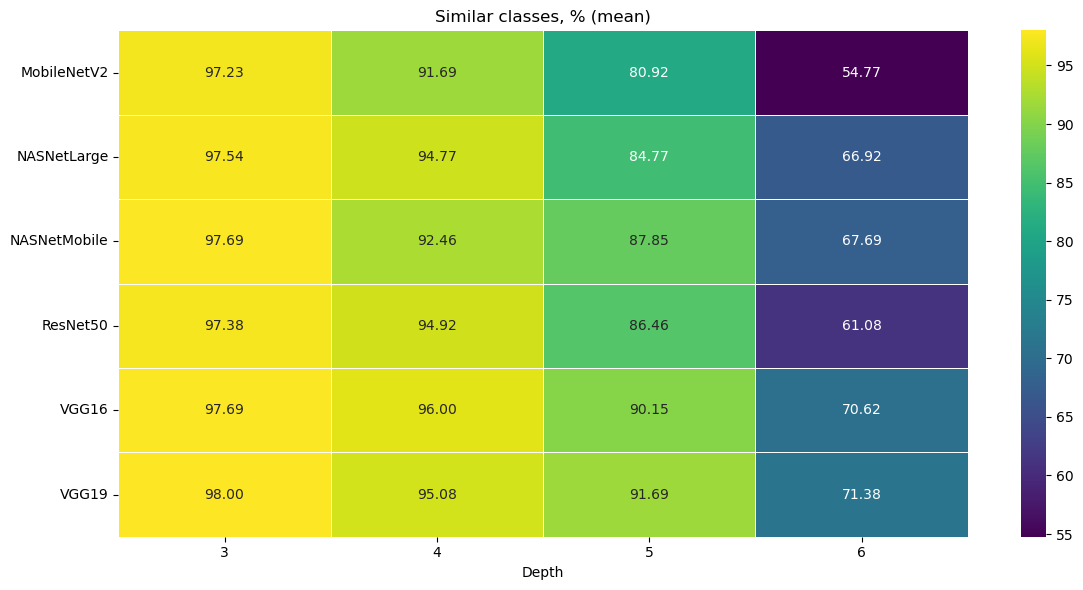

In [43]:
# classifiers = ['MobileNetV2', 'VGG16', 'VGG19', 'ResNet50', 'NASNetMobile', 'NASNetLarge']
depths = [3, 4, 5, 6]

x = rsltmgr.compare_summaries(classifiers, depths, "mean")
rsltmgr.visualize_comparison(x, SIM_CLASSES_PERC, title="Similar classes, % (mean)")

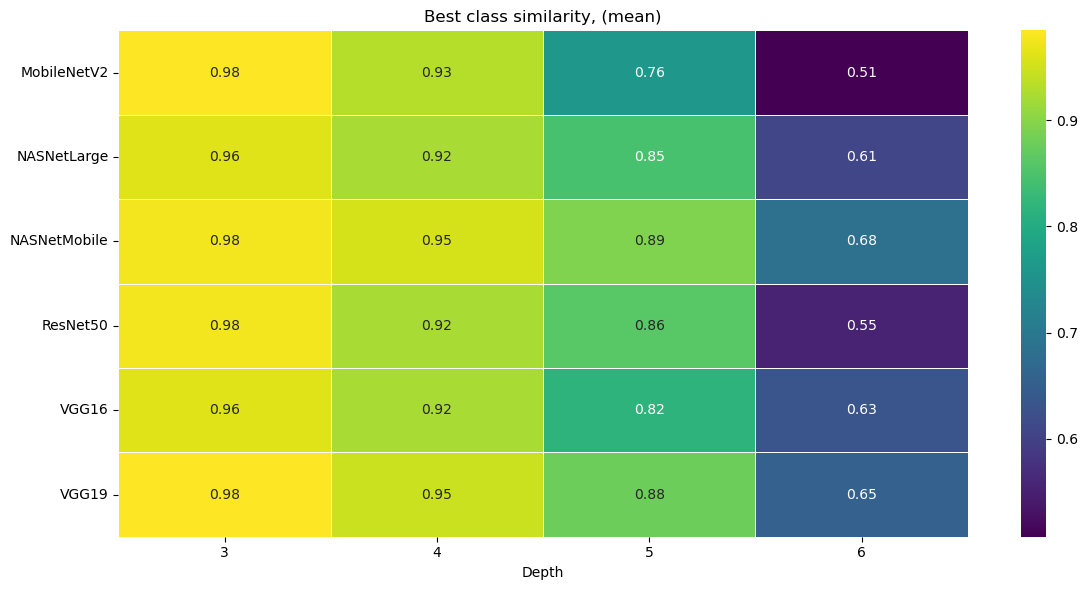

In [44]:
rsltmgr.visualize_comparison(x, SIM_BEST_CLASS, title="Best class similarity, (mean)")

# Key insights



### Model Performance at Depth 5
- **VGG Family Performance:** VGG16 and VGG19 demonstrate superior performance in similar class percentage metrics, with VGG19 outperforming VGG16 in maintaining classification consistency.
- **Best Class Similarity:** NASNet family models (particularly NASNetMobile) and ResNet50 excel at preserving the top predicted class despite compression, while VGG models show slightly lower performance in this metric.
- **MobileNetV2 Performance:** As expected, MobileNetV2 shows the weakest performance across all evaluation metrics, likely due to its architecture optimized for mobile deployment rather than robustness.
- **Surprising Finding:** Despite its smaller size, NASNetMobile demonstrates superior performance compared to NASNetLarge, suggesting that model complexity doesn't always correlate with compression resilience
### Compression Impact
- **Classification Consistency:** All models maintain at least 80.5% similarity in predicted classes between original and compressed images at depth 5.
- **Top Class Preservation:** For the best (top) class similarity, all models maintain at least 76% consistency between original and compressed versions.
- **Effect of Haar Compression:** The transformation significantly reduces image size while retaining recognizable features essential for classification.
### Depth Analysis (3-6)
- **Progressive Performance Decline:** Two distinct performance drops are observed as compression depth increases:
    - At depth 3: All models show metrics near 100% (minimal impact on classification)
    - At depth 5: Performance declines to 80-90% range
    - From depth 6: Significant degradation with metrics falling to 55-71%
### Conclusions
- Results suggest depth 5 represents an optimal balance between compression and classification performance for most models.
- For applications requiring large image processing, using compressed representations offers substantial storage/computational savings with acceptable classification performance.

# Next Steps
### API Implementation
- Develop a Flask-based API to expose the classification functionality as a service.
- Key API Endpoints:
  - `POST /classify`: Accept image uploads (original or compressed) and return classification results for all supported models.
  - `GET /models`: Retrieve a list of available classifiers and their supported functionalities (e.g., input size, preprocessing requirements).
  - `GET /compare`: Provide a summary comparison of model performance metrics for given depths (e.g., average similarity percentages).
- Include robust error handling and validation for uploaded images (e.g., format, size).
- Add support for batch image uploads to ensure scalability for large datasets.
- Integrate the Haar compression process, enabling clients to specify compression depth via API input.

### Future Research
- Extend analysis to other wavelet types (Daubechies, Coiflet) for better approximation properties and potentially improved classifier resilience after compression.
- Explore the impact of multi-wavelet techniques on performance consistency across various depths.
- Investigate adaptive compression techniques that adjust based on image content
- Explore the relationship between image content type and optimal compression parameters


### Additional Testing
- Evaluate classification performance using diverse datasets, including medical imaging, satellite photography, and cultural heritage archives, to validate findings across different image categories and characteristics.
- Benchmark computational efficiency gains from using compressed images
- Conduct ablation studies to identify which image features are most critical for classification preservation
